In [ ]:
!pip install category_encoders
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn import metrics as mt
from pandas_profiling import ProfileReport
from sklearn.inspection import permutation_importance

In [ ]:
test_data  = pd.read_csv(r'/content/Property_test_share.csv', na_values='missing')
train_data = pd.read_csv(r'/content/Property_train.csv', na_values='missing')

def remove_col(col):
  all_data.drop([col], axis=1, inplace=True)

#checking event rate 
#CHeck Target Variable
print('Target Variable : {0}'.format(set(train_data.columns)-set(test_data.columns)))
train_data['Junk'].value_counts(normalize=True)

Target Variable : {'Junk'}


0    0.877456
1    0.122544
Name: Junk, dtype: float64

In [ ]:
test_data['Junk']=np.nan
test_data=test_data[train_data.columns]
train_data['data']='train'
test_data['data']='test'
all_data = pd.concat([train_data,test_data], axis=0).reset_index(drop=True)
print(train_data.shape, test_data.shape, all_data.shape)

(62035, 32) (10948, 32) (72983, 32)


In [ ]:
#all_data[all_data.columns[~all_data.columns.isin(['Junk'])]]
all_data[['Month','Date','Year']]= all_data['ListDate'].str.split('/', expand=True).reset_index(drop=True)
del all_data['ListDate']

Treating Outliers

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


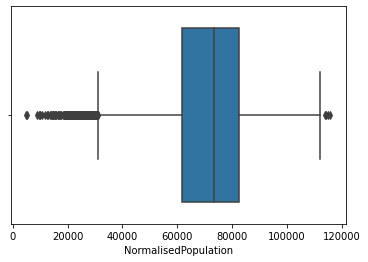

In [ ]:
%matplotlib inline
sns.boxplot(all_data['NormalisedPopulation'])

In [ ]:
all_data.drop(['NormalisedPopulation','ExpeditedListing'], axis=1, inplace=True)

Imputing Missing values with Nearest Neighbour

In [ ]:
#imputing missing values in numerical columns with mean/median
'''
for col in num_col:
  if ( all_data[col].isnull().sum() == 0 and col != 'Junk'):
    val=all_data[col].mean()
    print('Column name:{0}\n\tUnique Value : {1}\n\tNull Value : {2}\n\tImpute Value : {3}'.format(col, all_data[col].nunique(), all_data[col].isnull().sum(), val))
    all_data[col]=all_data[col].fillna(val)
    print('\tNull Value after impute : {0}'.format(all_data[col].isnull().sum()))
'''    

#imputing missing values with nearest neighbours
col_to_impute=['PriceIndex1', 'PriceIndex2','PriceIndex3','PriceIndex4','PriceIndex5','PriceIndex6','PriceIndex7','PriceIndex8']
new_col=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8']

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5, weights='uniform')

all_data[new_col]        = imputer.fit_transform(np.array(all_data[col_to_impute]))
#all_data[col_to_impute2] = imputer.fit_transform(np.array(all_data[col_to_impute2]))

new_col.append('PriceIndex9')

all_data['PriceIndex']=all_data[new_col].mean(axis=1).round(2)

all_data.drop(new_col, axis=1, inplace=True)
all_data.drop(col_to_impute, axis=1, inplace=True)

Using IQR to find outliers

In [ ]:
#Using stats
from scipy import stats
num_col=all_data.select_dtypes(['int64','float64'])

# thresh=3
# for coln in num_col:
#   if ((np.abs(stats.zscore(all_data[coln])) > thresh).any() and coln != 'Junk'):
#     print('\n\nOutlier detected in column : {0}\nReplacing Outlier with nan values'.format(coln))
#     all_data.loc[np.abs(stats.zscore(all_data[coln])) > 3, coln]=all_data[coln].median()

#Using IQR
for coln in num_col:
  q1=all_data[coln].quantile(0.25)
  q3=all_data[coln].quantile(0.75)
  iqr=q3-q1
  lower_layer=q1-1.5*iqr
  upper_layer=q3+1.5*iqr
  if (np.logical_or(all_data[coln] > upper_layer , all_data[coln] < lower_layer).any() and coln != 'Junk'):
    print(coln)
    all_data.loc[np.logical_or(all_data[coln] >= upper_layer , all_data[coln] < lower_layer), coln]=all_data[coln].median()

InsurancePremiumIndex
PropertyAge
PriceIndex


In [ ]:
#Calculating the frequency of occurence of value, used for high cardinal data
value_cnt = dict(all_data['InteriorsStyle'].value_counts())
for k in value_cnt:
  all_data.loc[all_data['InteriorsStyle']==k,'InteriorsStyle_freq']=value_cnt.get(k)
all_data.drop('InteriorsStyle', axis=1, inplace=True)

value_cnt=dict()
value_cnt = dict(all_data['SubModel'].value_counts())
for k in value_cnt:
  all_data.loc[all_data['SubModel']==k,'SubModel_freq']=value_cnt.get(k)
all_data.drop('SubModel', axis=1, inplace=True)
#Dropping Build Year and ZIP
all_data.drop(['BuildYear', 'Zip'], axis=1,inplace=True)

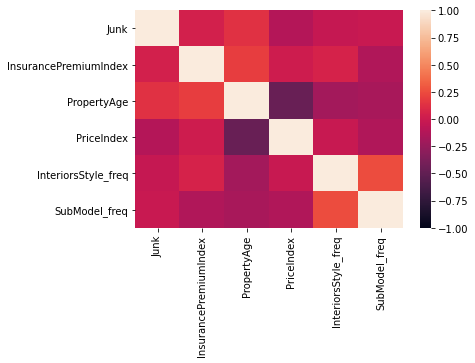

In [ ]:
%matplotlib inline
sns.heatmap(all_data.corr(), vmin=-1, vmax=1)

Using Pandas profiling to study dataset

In [ ]:
#!pip install pandas-profiling==2.7.1
#ProfileReport(all_data)

Defining decile plot function to study behaviour or variable along with its event rate

In [ ]:
def decile_plot(dataframe, x, target, cut=10):
  dec_plt=pd.DataFrame()
  all_data_plt=dataframe.copy()
  #all_data_plt[x] = all_data_plt[x].astype(int)
  if (all_data_plt[x].dtype == 'object'):
    all_data_plt['decile'] = all_data_plt[x]
  else:
    all_data_plt[x] = all_data_plt[x].astype(int)
    all_data_plt['decile']=pd.qcut(all_data_plt[x], q=cut, retbins=False, duplicates='drop', labels=False)
  dec_plt[['decile','min_val','max_val','ones','total']]=all_data_plt.groupby('decile').agg({x:['min' , 'max'], target:['sum', 'count']}).reset_index()
  dec_plt['decile']=dec_plt['decile'].astype('str')
  #dec_plt['decile_rank']=dec_plt['decile'].rank(ascending=1)
  dec_plt.reset_index(inplace=True)
  dec_plt['event_rate']=100*dec_plt['ones']/dec_plt['total']

  ##Plotting graph

  fig , ax1 = plt.subplots()
  color='tab:green'
  ax1.set_xlabel('Decile')
  ax1.set_ylabel('Total Records', color=color)
  ax1.bar(dec_plt['decile'], dec_plt['total'], color=color)
  ax1.tick_params(axis='y', labelcolor=color)

  ax2=ax1.twinx()

  color='tab:red'
  ax2.set_ylabel('Event Rate(%)', color=color)
  ax2.plot(dec_plt['decile'], dec_plt['event_rate'], color=color)
  ax2.tick_params(axis='y', labelcolor=color)
  ax1.set_title('{} vs {}'.format(x, target))
  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  plt.show()

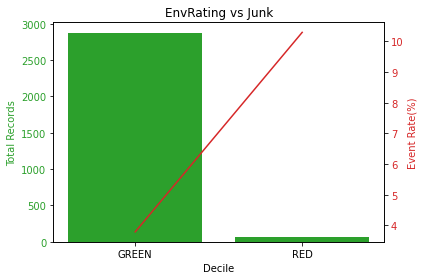

In [ ]:
decile_plot(all_data, 'EnvRating', 'Junk')

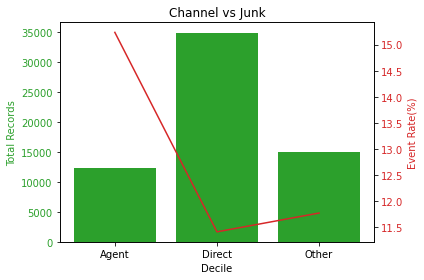

In [ ]:
#'PRIMEUNIT','EnvRating'
decile_plot(all_data, 'Channel', 'Junk')

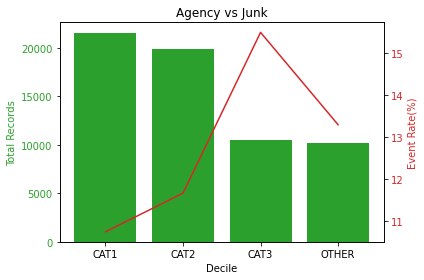

In [ ]:
decile_plot(all_data, 'Agency', 'Junk')

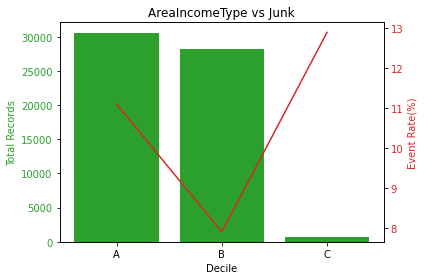

In [ ]:
decile_plot(all_data, 'AreaIncomeType', 'Junk')

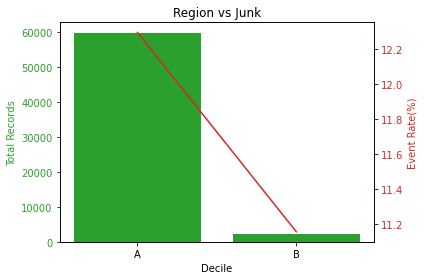

In [ ]:
decile_plot(all_data, 'Region', 'Junk')

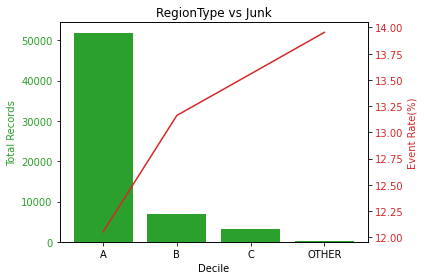

In [ ]:
decile_plot(all_data, 'RegionType', 'Junk')

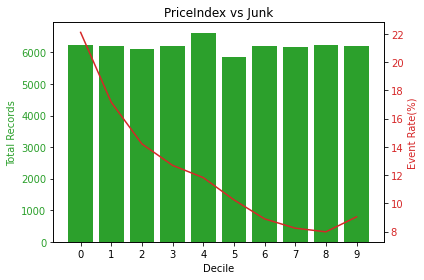

In [ ]:
decile_plot(all_data,'PriceIndex','Junk')

Handling Categorical variables

In [ ]:
all_data.select_dtypes(['object']).isna().sum()

Material              0
Agency                5
AreaIncomeType     3174
EnvRating         69564
PRIMEUNIT         69564
Channel               0
PlotType              0
Architecture          0
Region                9
Facade                8
State                 0
RegionType            5
data                  0
Month                 0
Date                  0
Year                  0
dtype: int64

Imputing missing values in categorical variables wih nearest neighbour

In [ ]:
col_to_impute=[]
encoder_dict=dict()
decoder_dict=dict()

col_to_impute=['Agency','AreaIncomeType','Region','RegionType']

#Creating labels for all column values
for col in col_to_impute:
  encoder_dict[col]={key:value for value, key in enumerate(all_data.loc[all_data[col].notnull(), col].unique(), start=1)}

#encoding columns with numerical value
all_data.replace(encoder_dict, inplace=True)

#imputing Missing values
cat_imputer=KNNImputer(n_neighbors=3, weights='distance')
all_data[col_to_impute]=np.round(cat_imputer.fit_transform(all_data[col_to_impute]))

#decoding numerical to categorical
for col in col_to_impute:
  decoder_dict[col]={float(value):key for key ,value in encoder_dict[col].items()}

all_data.replace(decoder_dict, inplace=True)

In [ ]:
#col_to_impute.append('Channel')
# for col in col_to_impute:
#   for ind in np.array(all_data[col].value_counts().index[:-1]):
#     freq = 15
#     if ((all_data[col].value_counts(normalize=True)[ind]*100) > freq):
#       name = str(col)+'_'+str(ind)
#       all_data[name]=np.where(all_data[col]==ind, 1,0)
#   all_data.drop([col], axis=1, inplace=True)

all_data['PRIMEUNIT_NO'] = np.where(all_data['PRIMEUNIT'] == 'NO',1,0)
all_data['EnvRating_green'] = np.where(all_data['EnvRating'] == 'GREEN',1,0)
all_data['Channel_Agent']    = np.where(all_data['Channel'] == 'Agent',1,0)
all_data['Agency_CAT_1_2']   = np.where(np.logical_or(all_data['Agency']=='CAT1', all_data['Agency']=='CAT2') , 1, 0)
all_data['Agency_CAT_3']     = np.where(all_data['Agency']=='CAT3', 1, 0)
all_data['AreaIncomeType_B'] = np.where(all_data['AreaIncomeType']=='B' , 1, 0)
all_data['Region_A']         = np.where(all_data['Region']=='A' , 1, 0)
all_data['RegionType_A']     = np.where(all_data['RegionType']=='A', 1, 0)

#remove_col(['PRIMEUNIT','EnvRating','ExpeditedListing','Channel'])
all_data.drop(['Agency','AreaIncomeType','Region','RegionType'], axis=1, inplace=True  )
all_data.drop(['PRIMEUNIT','EnvRating','Channel'], axis=1, inplace=True)

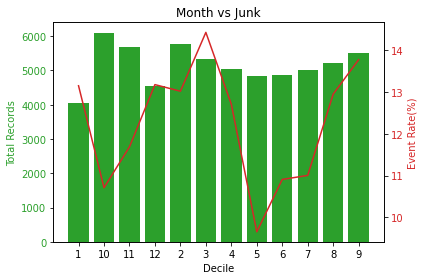

In [ ]:
decile_plot(all_data, 'Month', 'Junk', 3)

In [ ]:
# all_data_test = all_data.copy()
# all_data_test['Month']=all_data_test['Month'].astype(int)
# all_data_test['decile'] = pd.qcut(all_data_test['Month'], q=5, retbins=False, duplicates='drop', labels=False)
# all_data_test.loc[all_data_test['decile']==0, 'Month'].unique()
# 1,2,3 months are in decile 0 so will bucketize decile 1 to 4
all_data['Month_4_12'] =np.where(all_data['Month'].astype(int)>3, 1, 0)

In [ ]:
all_data['PlotType'].value_counts(normalize=True)*100

WHBI    42.181056
W62B    12.126112
32T2    11.084773
DIJX     9.872162
WLQ6     8.021046
DSSM     4.343477
DJOP     3.118534
7RBQ     2.623899
I00H     2.410150
V5R0     1.963471
8FRL     1.183837
LIGY     1.064631
T559     0.006851
Name: PlotType, dtype: float64

In [ ]:
all_data.groupby(['PlotType'])['Junk'].mean()

PlotType
32T2    0.147536
7RBQ    0.092840
8FRL    0.145228
DIJX    0.156715
DJOP    0.142932
DSSM    0.115342
I00H    0.105947
LIGY    0.182515
T559    0.000000
V5R0    0.164228
W62B    0.091918
WHBI    0.113418
WLQ6    0.130374
Name: Junk, dtype: float64

In [ ]:
#all_data['PlotType_cat'] = np.where(all_data.isin(['7RBQ','T559','W62B'])['PlotType'], 0, 1)
#all_data['Material'].value_counts(normalize=True)
#all_data['Material_cat'] = np.where(all_data.isin(['PRN0','C8A4','ZCI3'])['Material'], 1, 0)

all_data['Facade'].value_counts(normalize=False)
all_data.groupby(['Facade'])['Junk'].mean()
#dropping variable as target rate is evenly distributed for all

pd.crosstab(all_data['Month'], all_data['Junk'], margins=True, normalize=True)*100
#avoid bucketizing as there is no fixed pattern inside 1 decile, random forest will consider it but for logistic can drop this column
all_data.drop(['PlotType', 'Material','Facade', 'Architecture','Month','Date','Year'] , axis=1, inplace=True)

In [ ]:
all_data['State_1'] = np.where(all_data.isin(['AL','AZ','CA','CO','FL','GA','MD','NC','NJ','NM','TN','UT'])['State'], 1, 0)
all_data['State_2'] = np.where(all_data.isin(['IA','IL','IN','LA','NV','SC','TX','VA'])['State'], 1 , 0)
all_data['State_3'] = np.where(all_data.isin(['ID','MA','MI','MO','MS','OH','OK','WV'])['State'], 1 , 0)
all_data['State_4'] = np.where(all_data.isin(['KY','MN','NE','NH','NY','OR','WA'])['State'], 1 , 0)
all_data['State_5'] = np.where(all_data.isin(['AR','PA'])['State'], 1 , 0)
remove_col('State')

In [ ]:
all_data.select_dtypes(['object'])

,data
0,train
1,train
2,train
3,train
4,train
...,...
72978,test
72979,test
72980,test
72981,test


In [ ]:
#Seperating train-test data
#if copy is removed then set warnign occurs
#all_data.drop(['State_5', 'State_2','State_3', 'Region_A','RegionType_A'], axis=1, inplace=True)
#all_data_copy1 = all_data.copy()
#all_data = all_data_copy1.copy()
#all_data.drop(['Agency_CAT_3', 'State_2', 'Region_A','RegionType_A', 'Month_4_12', 'State_3', 'State_5'], axis=1,inplace=True)
train_data = all_data[all_data['data']=='train'].copy()
test_data = all_data[all_data['data']=='test'].copy()
train_data.drop(['data'],axis=1, inplace=True)
test_data.drop(['data'],axis=1, inplace=True)

train_data.shape, test_data.shape

((62035, 20), (10948, 20))

In [ ]:
#train-test split
#Splitting train data
#test_data will be used for final scoring
#train_data = train_data.sample(frac=1)

#stratifying while train-test split as to make the event rate uniform in train and test data
from sklearn.model_selection import train_test_split
train_d, test_d = train_test_split(train_data, test_size=0.3, stratify=train_data['Junk'])
x_train=train_d.drop(['Junk'], axis=1)
y_train=train_d['Junk']

x_test=test_d.drop(['Junk'], axis=1)
y_test=test_d['Junk']

train_d.shape, test_d.shape

((43424, 20), (18611, 20))

In [ ]:
#train_d['Junk'].value_counts(normalize=True)*100
test_d['Junk'].value_counts(normalize=True)*100

0.0    87.743807
1.0    12.256193
Name: Junk, dtype: float64

In [ ]:
all_data.isnull().sum()

Junk                     10948
InsurancePremiumIndex        0
PropertyAge                  0
data                         0
PriceIndex                   0
InteriorsStyle_freq          0
SubModel_freq                0
PRIMEUNIT_NO                 0
EnvRating_green              0
Channel_Agent                0
Agency_CAT_1_2               0
Agency_CAT_3                 0
AreaIncomeType_B             0
Region_A                     0
RegionType_A                 0
Month_4_12                   0
State_1                      0
State_2                      0
State_3                      0
State_4                      0
State_5                      0
dtype: int64

Data Modelling
---
**Random Forest Classifier**



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rfc=RandomForestClassifier(verbose=0, n_jobs=-1)
n_iter_search=5

param_dist= {
    'n_estimators'     :[400,600,500],
    'criterion'        :['gini','entropy'],
    'max_features'     :[5,7,10],
    'min_samples_split':[3,5,7],
    #'min_samples_leaf' :[5,7,10],
    'bootstrap'        :[False, True],
    'class_weight'     :['balanced','balanced_subsample'],#'class_weight'     :['balanced_subsample','balanced'],
    'max_samples'      :[5,7,8],
    'max_depth'        :[5,8,10]
 } 
random_search = RandomizedSearchCV(rfc, param_distributions=param_dist, cv=5, n_iter=n_iter_search, scoring='roc_auc')
random_search.fit(x_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
 def report (random_search, top_list=3):
  for rank, i in enumerate(np.argsort(random_search.cv_results_['rank_test_score'])[:top_list]):
    print('Model with rank : {0}'.format(rank+1))
    print('Mean Validation Score :  {0:.3f} (std: {1:.3f})'.format(
        random_search.cv_results_['mean_test_score'][i],
        random_search.cv_results_['std_test_score'][i]))
    print('\nMean Test Score : {0}'.format(random_search.cv_results_['mean_test_score'][i]))
    print('\nParameters : {0}'.format(random_search.cv_results_['params'][i]))
    print("="*40)    

report(random_search)

Model with rank : 1
Mean Validation Score :  0.675 (std: 0.008)

Mean Test Score : 0.6746925877414144

Parameters : {'n_estimators': 600, 'min_samples_split': 7, 'max_samples': 8, 'max_features': 7, 'max_depth': 10, 'criterion': 'gini', 'class_weight': 'balanced', 'bootstrap': False}
Model with rank : 2
Mean Validation Score :  0.674 (std: 0.008)

Mean Test Score : 0.6736832889467548

Parameters : {'n_estimators': 500, 'min_samples_split': 3, 'max_samples': 5, 'max_features': 5, 'max_depth': 8, 'criterion': 'entropy', 'class_weight': 'balanced', 'bootstrap': False}
Model with rank : 3
Mean Validation Score :  0.669 (std: 0.008)

Mean Test Score : 0.6691098780407789

Parameters : {'n_estimators': 400, 'min_samples_split': 5, 'max_samples': 7, 'max_features': 10, 'max_depth': 8, 'criterion': 'entropy', 'class_weight': 'balanced', 'bootstrap': False}


In [ ]:
#finding best estimmator
rf=random_search.best_estimator_

#AUC: 72%
'''
RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=8, max_features=8, max_leaf_nodes=None,
                       max_samples=8, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=7,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=700, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
'''   
#AUC : 84%
'''
rf = RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=12, max_features=8, max_leaf_nodes=None,
                       max_samples=7, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=10,
                       min_samples_split=4, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)


'''
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features=7,
                       max_leaf_nodes=None, max_samples=8,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
from sklearn import metrics as mt
score_df = pd.DataFrame()
roc_score_data=[]
min_sample_splt = np.linspace(2,10,9).astype(int)
for val in min_sample_splt:
  rf = RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=12, max_features=8, max_leaf_nodes=None,
                       max_samples=7, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=10,
                       min_samples_split=val, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
  rf.fit(x_train, y_train)

  x_pred = rf.predict(x_train)
  x_pred_prob=rf.predict_proba(x_train)
  
  y_pred     =rf.predict(x_test)
  y_pred_prob=rf.predict_proba(x_test)

  roc_score_data.append(['Train', mt.roc_auc_score(y_train, x_pred_prob[:,1]) ])
  roc_score_data.append(['Test' ,  mt.roc_auc_score(y_test, y_pred_prob[:,1]) ])

score_df = pd.DataFrame(roc_score_data , columns=['Data', 'Score'])

In [ ]:
score_df.head()

**Calculating Scores manually of TRAIN Data**

In [ ]:
x_pred     =rf.predict(x_train)
x_pred_prob=rf.predict_proba(x_train)

real_pred = pd.DataFrame(list(zip(y_train,x_pred)), columns=['real', 'predicted'])
k=pd.crosstab(real_pred['real'], real_pred['predicted'])
k

predicted,0.0,1.0
real,,
0.0,24585,13518
1.0,1442,3879


In [ ]:
TP=k.iloc[1,1]
TN=k.iloc[0,0]
FP=k.iloc[0,1]
FN=k.iloc[1,0] 

P=TP+FN
N=TN+FP

print('Accuracy is :',(TP+TN)/(P+N))
print('Sensitivity is :',TP/P)
print('Specificity is :',TN/N)

Accuracy is : 0.6554900515843773
Sensitivity is : 0.7289983085886111
Specificity is : 0.6452247854499645


Calc Scores using SKLEARN of TRAIN data

In [ ]:
from sklearn import metrics as mt
print('Train Data Score : {0:.3f}'.format(rf.score(x_train, y_train)))

print('\nAccuracy : {0:.3f}'.format(mt.accuracy_score(y_train, x_pred)))

print('\nRecall : {0:.3f}'.format(mt.recall_score(y_train, x_pred)))
print('Precission : {0:.3f}'.format(mt.precision_score(y_train, x_pred)))

print('\nAUC : {0:.3f}'.format(mt.roc_auc_score(y_train, x_pred_prob[:,1]) ))
print('F-Beta Score : {0:.3f}'.format(mt.fbeta_score(y_train, x_pred, beta=2)))

Train Data Score : 0.655

Accuracy : 0.655

Recall : 0.729
Precission : 0.223

AUC : 0.771
F-Beta Score : 0.501


Calc Scores using SKLEARN of TEST data

In [ ]:
xt_pred     =rf.predict(x_test)
xt_pred_prob=rf.predict_proba(x_test)

realt_pred = pd.DataFrame(list(zip(y_test,xt_pred)), columns=['real', 'predicted'])
kt=pd.crosstab(realt_pred['real'], realt_pred['predicted'])
kt

predicted,0.0,1.0
real,,
0.0,10171,6159
1.0,930,1351


In [ ]:
y_pred     =rf.predict(x_test)
y_pred_prob=rf.predict_proba(x_test)
print('Test Data Score : {0:.3f}'.format(rf.score(x_test, y_test)))

print('Accuracy : {0:.3f}'.format(mt.accuracy_score(y_test, y_pred)))

print('\nRecall : {0:.3f}'.format(mt.recall_score(y_test, y_pred)))
print('Precission : {0:.3f}'.format(mt.precision_score(y_test, y_pred)))

print('\nAUC : {0:.3f}'.format(mt.roc_auc_score(y_test, y_pred_prob[:,1]) ))
print('F-Beta Score : {0:.3f}'.format(mt.fbeta_score(y_test, y_pred, beta=2)))

Test Data Score : 0.619
Accuracy : 0.619

Recall : 0.592
Precission : 0.180

AUC : 0.651
F-Beta Score : 0.406


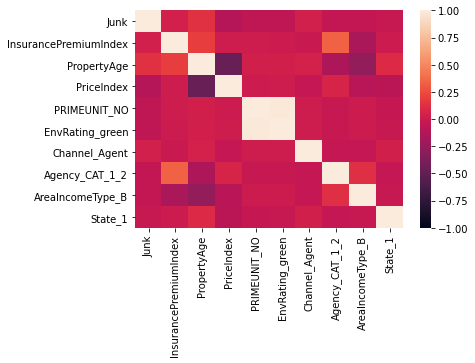

In [ ]:
sns.heatmap(all_data.corr(),  vmin=-1, vmax=1)

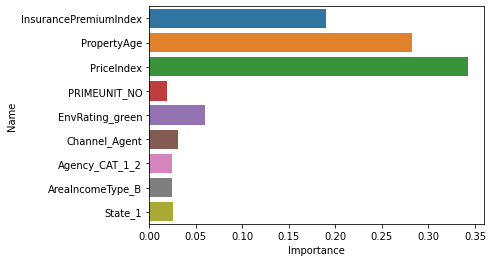

In [ ]:
feat_imp=pd.DataFrame(list(zip(x_train.columns, rf.feature_importances_)), columns=['Name', 'Importance'])
sns.barplot(y=feat_imp['Name'], x=feat_imp['Importance'])

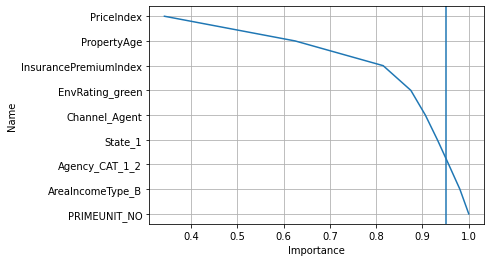

In [ ]:
feat_imp.sort_values('Importance', ascending=False, inplace=True)
importances = feat_imp['Importance']
featuress   = feat_imp['Name']

cum_importance = np.cumsum(importances)
graph = sns.lineplot(x= cum_importance, y= featuress)
dashed_line_point  = max(cum_importance)*0.95
graph.grid()
graph.axvline(dashed_line_point)

plt.show()

In [ ]:
#feat_imp.iloc[np.where(cum_importance>=0.95)]['Name']
all_data.drop(['Agency_CAT_3', 'State_2', 'Region_A','RegionType_A', 'Month_4_12', 'State_4','State_3', 'State_5'], axis=1,inplace=True)

In [ ]:
#By dropping above columns we can check if it is making our model scores better than previous scores